# Imports

In [5]:
import os
import sys 
import json
import pickle
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib

from scipy import stats
from pylab import rcParams
from scipy.stats import randint
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

rcParams['figure.figsize'] = (16, 9)
matplotlib.rcParams['figure.figsize'] = (16, 9)

In [6]:
data = pd.read_csv('data/household_power_consumption.txt', sep=';', 
                   parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                   low_memory=False, na_values=['nan','?'], index_col='dt')

In [7]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [8]:
data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


# Exploratory data analysis

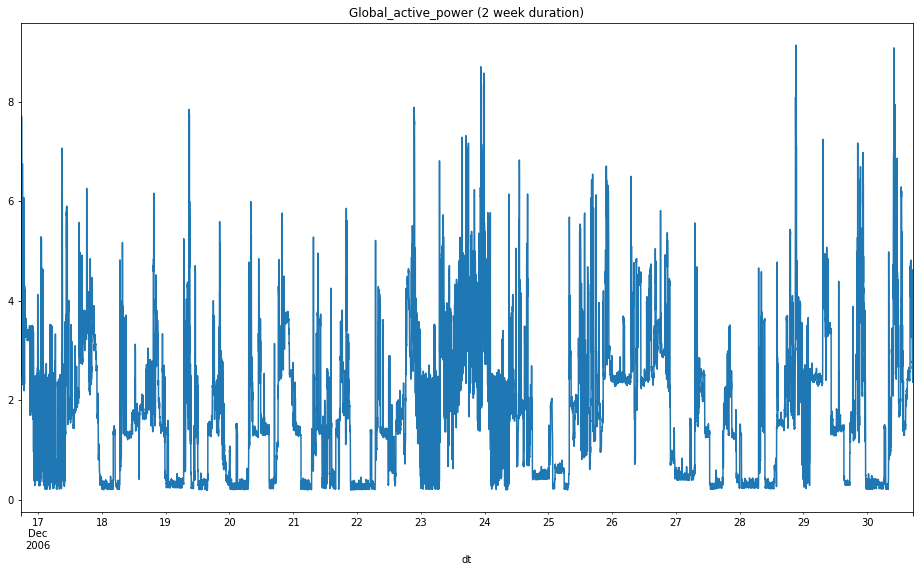

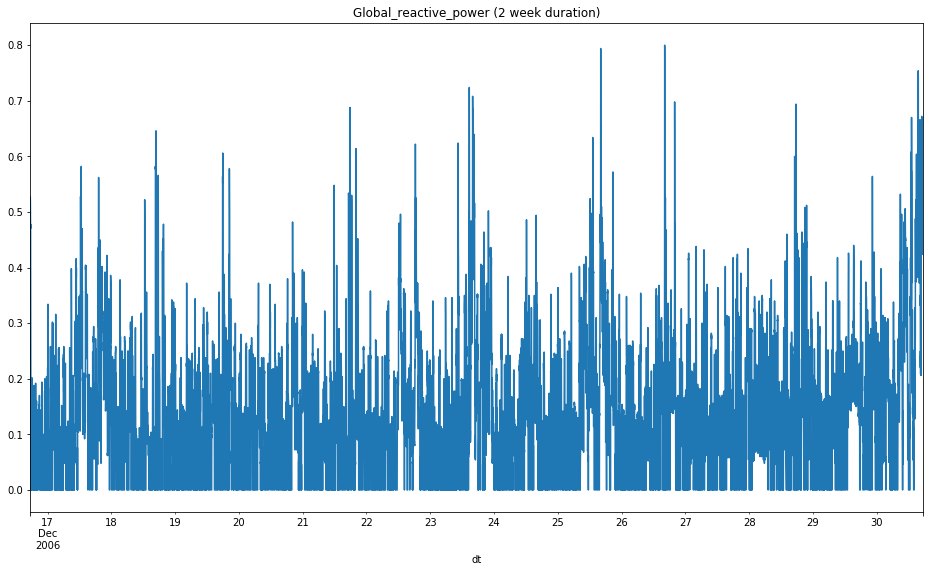

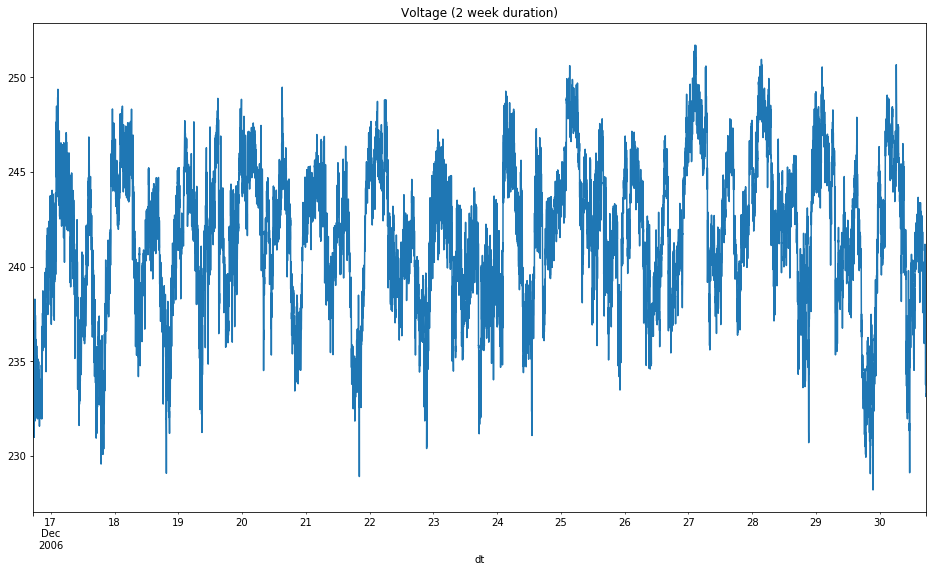

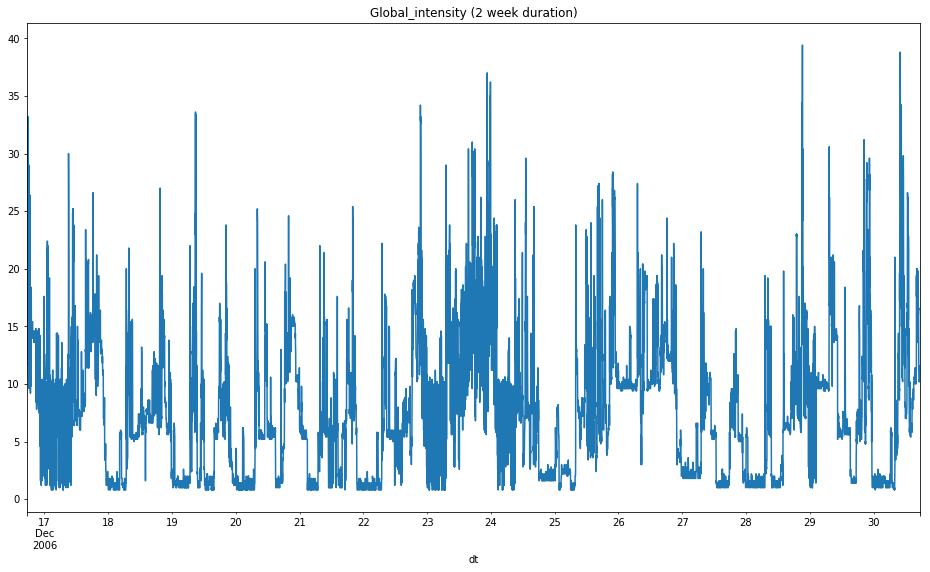

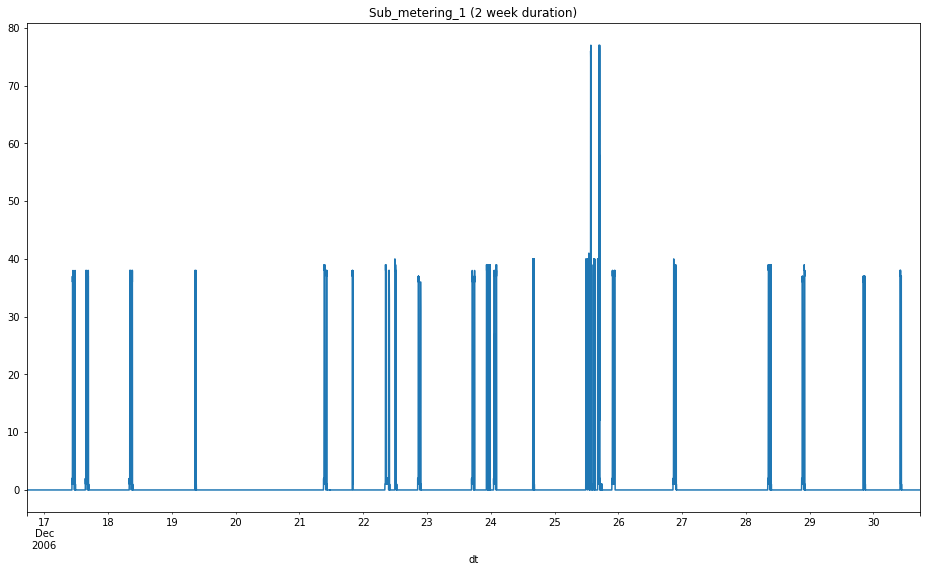

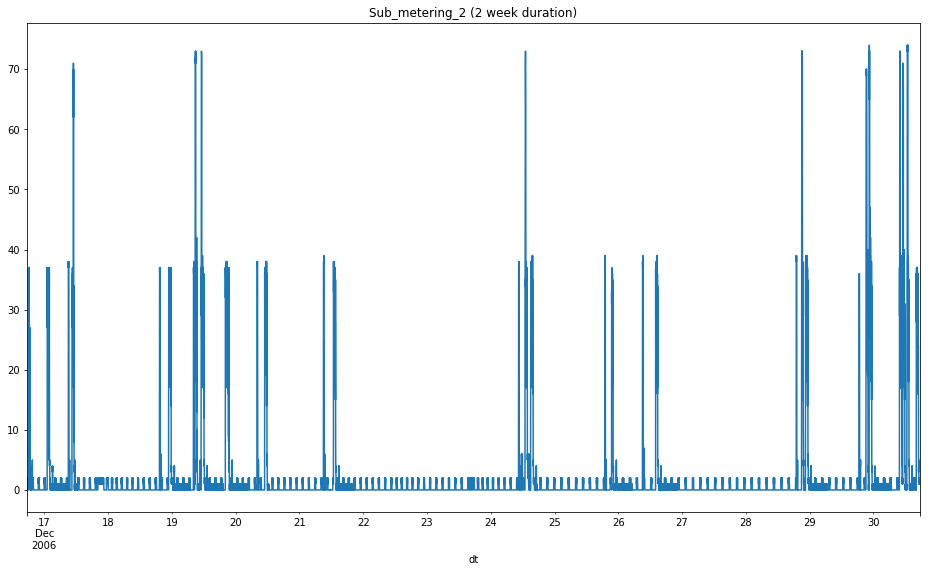

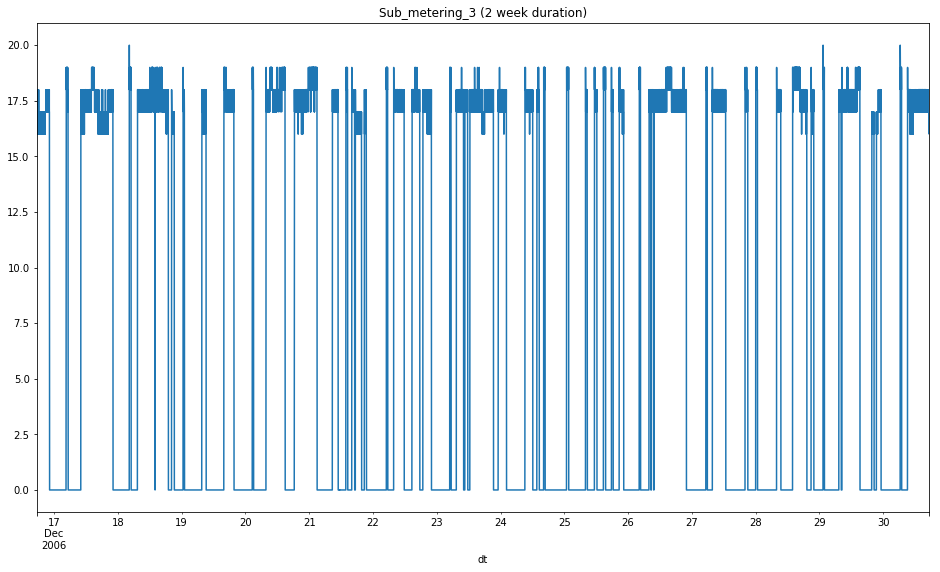

In [9]:
for column in data.columns:
    plt.title(f'{column} (2 week duration)')
    data[column][:60*24*14].plot()
    plt.show()

Для простоты будем работать с **дневным** потреблением электричества (*Global active power*), посмотрим внимательнее на данные.

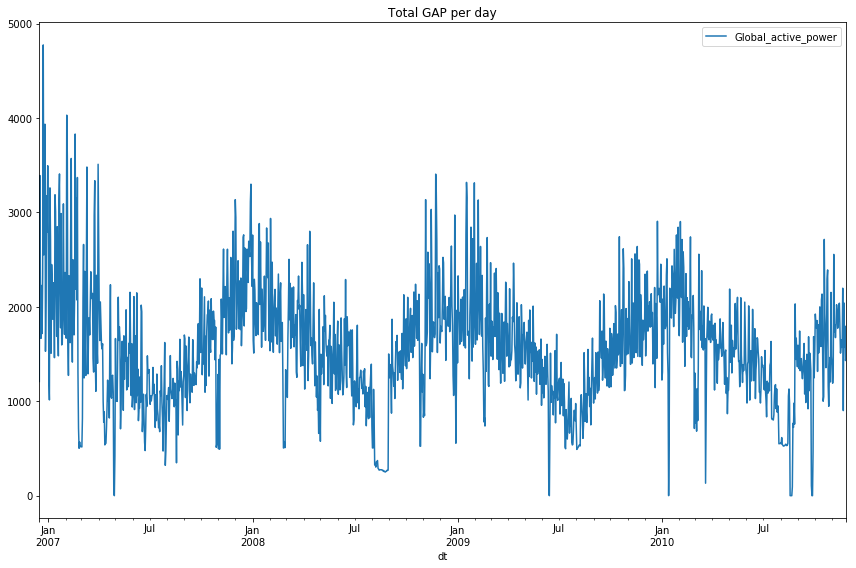

In [10]:
data[['Global_active_power']].resample('D').apply(sum).plot(title='Total GAP per day', figsize=(12, 8)) 
plt.tight_layout()
plt.show()

## Задание: Что не так с этим графиком?

In [11]:
data.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

В данных пропусков примерно на 18 дней, интерполируем пропущенные значения.

In [12]:
data.interpolate(method='time', inplace=True)
data.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [13]:
data['Global_active_power'].describe()

count    2.075259e+06
mean     1.090280e+00
std      1.052628e+00
min      7.600000e-02
25%      3.100000e-01
50%      6.140000e-01
75%      1.528000e+00
max      1.112200e+01
Name: Global_active_power, dtype: float64

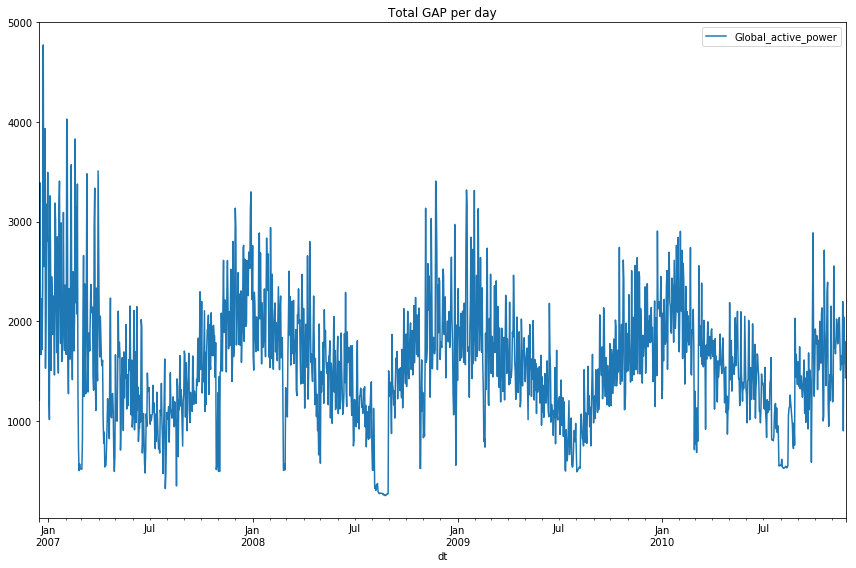

In [14]:
data[['Global_active_power']].resample('D').apply(sum).plot(title='Total GAP per day', figsize=(12, 8)) 
plt.tight_layout()
plt.show()

# Простые бейзлайн решения для прогнозирования рядов

### Посчитаем ошибки прогноза:
MAPE (mean absolute percentage error) — это средняя абсолютная ошибка нашего прогноза. MAPE часто используется для оценки качества, поскольку эта величина относительная и по ней можно сравнивать качество даже на различных наборах данных.

$y_i$ - значение ряда в момент времени $i$.  
$\hat{y_i}$ - прогноз нашей модели в то же время.  

$e_i = y_i - \hat{y_i}$ - ошибка прогноза.  
$p_i = \frac{e_i}{y_i}$ - относительная ошибка прогноза.

$MAE = mean\space (\mid{e_i}\mid)$  
$MAPE = mean\space (\mid{p_i}\mid)$

### Задание: реализовать функции для подсчёта MAE, MAPE

In [87]:
def mean_abs_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [86]:
def mean_abs_percentage_error(y_true, y_pred):
     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Прогнозирование вчерашним днём

In [17]:
def plot_prediction(gt, pred, last_n=60, title='Graph'):
    plt.plot(pred[-last_n:], label='Prediction')
    plt.plot(gt[-last_n:], label='Ground Truth')
    plt.title(title)
    plt.grid(True)
    plt.legend()

In [18]:
df = data['Global_active_power'].resample('D').apply(sum)
prediction = df.shift(1)

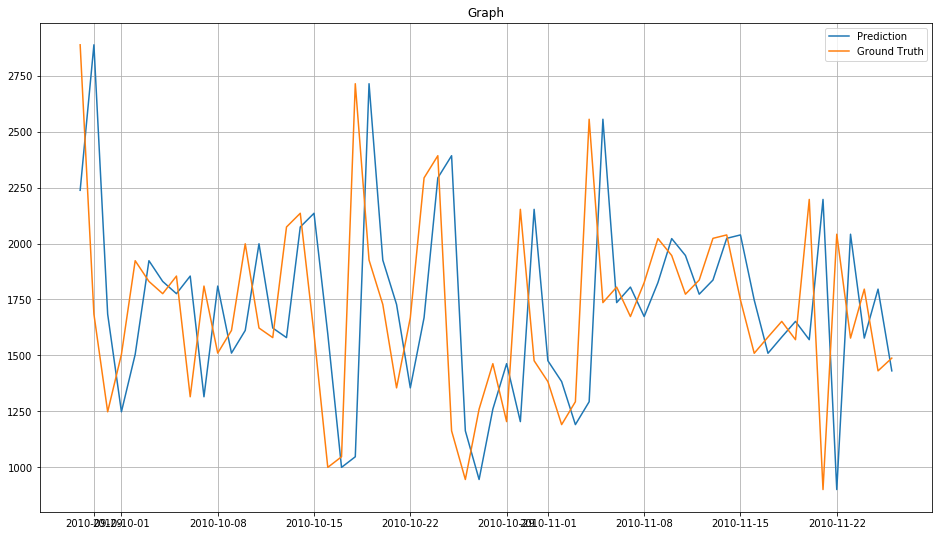

In [19]:
plot_prediction(df, prediction)

In [20]:
print(f'Naive MAE = {mean_abs_error(df[1:], prediction.dropna())}')
print(f'Naive MAPE = {mean_abs_percentage_error(df[1:], prediction.dropna())}')

NameError: name 't_true' is not defined

## Скользящее среднее

In [23]:
prediction = df.rolling(7).apply(np.mean).shift(1)

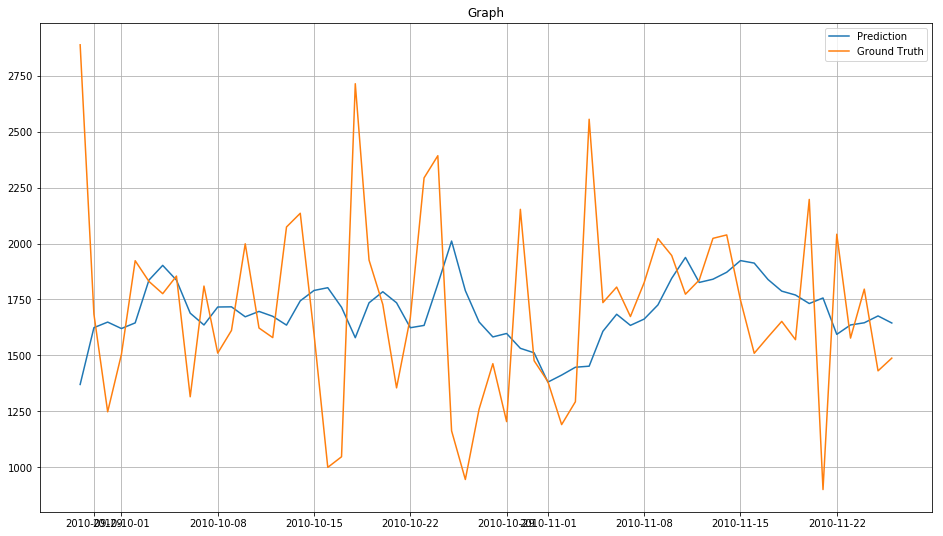

In [24]:
plot_prediction(df, prediction)

In [25]:
print(f'Moving average MAE = {mean_abs_error(df[7:], prediction.dropna())}')
print(f'Moving average MAPE = {mean_abs_percentage_error(df[7:], prediction.dropna())}')

Moving average MAE = -1.4602896963663439
Moving average MAPE = -146.0289696366344


## Экспоненциальные сглаживания

In [26]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result, index=series.index)

prediction = exponential_smoothing(df, 0.7)

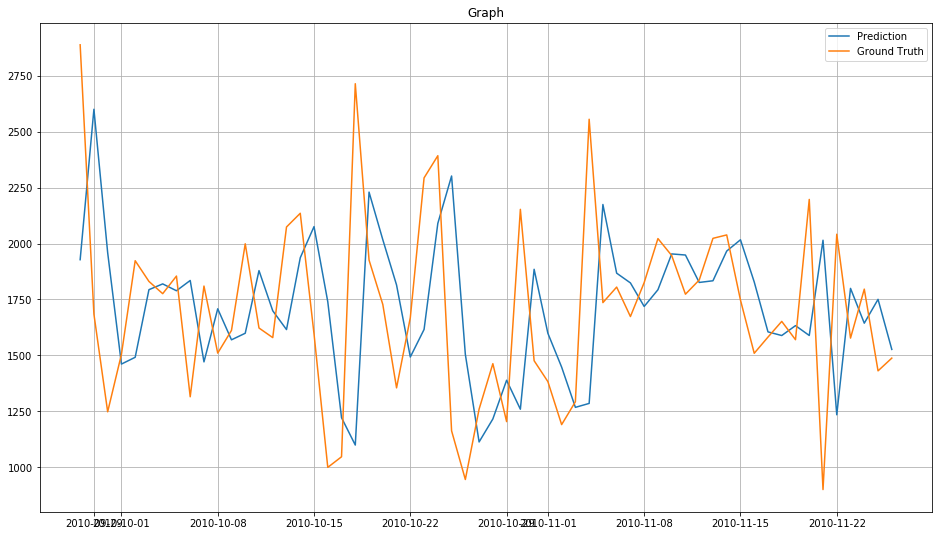

In [27]:
plot_prediction(df, prediction.shift(1))

In [28]:
print(f'Exponential smoothing MAE = {mean_abs_error(df[1:], prediction.shift(1).dropna())}')
print(f'Exponential smoothing MAPE = {mean_abs_percentage_error(df[1:], prediction.shift(1).dropna())}')

Exponential smoothing MAE = 0.2880905630432563
Exponential smoothing MAPE = 28.80905630432563


## Взвешенное скользящее среднее

In [29]:
def weighted_average(series, weights):
    if np.sum(weights) != 1:
        raise ValueError('Weights must sum to 1')
    weights.reverse()
    window_size = len(weights)
    w_fn = lambda x: np.sum(weights * x)
    return series.rolling(window_size).apply(w_fn)

prediction = weighted_average(df, [0.6, 0.2, 0.1, 0.07, 0.03])

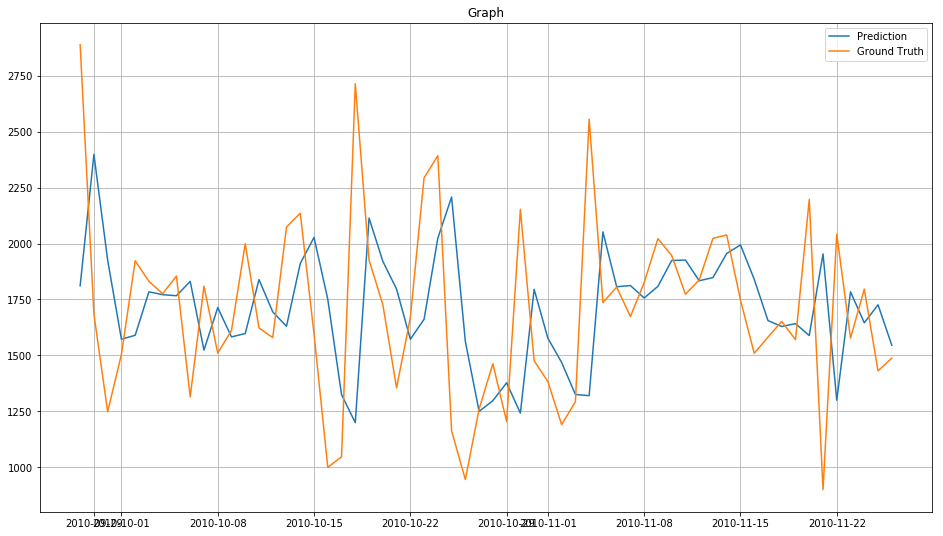

In [30]:
plot_prediction(df, prediction.shift(1))

In [31]:
print(f'Weighted moving average MAE = {mean_abs_error(df[5:], prediction.shift(1).dropna())}')
print(f'Weighted moving average MAPE = {mean_abs_percentage_error(df[5:], prediction.shift(1).dropna())}')

Weighted moving average MAE = -0.7442541405706233
Weighted moving average MAPE = -74.42541405706234


# ARIMA

## Краткая теория по временным рядам

В классических задачах анализа данных предполагается что все наблюдение независимы, однако при прогнозировании временных рядов, мы наоборот, надеемся, что значения ряда в прошлом содержат информацию о его поведении в будущем.

### Компоненты временных рядов:

**Тренд** — плавное долгосрочное изменение уровня ряда.  
**Сезонность** — циклические изменения уровня ряда с постоянным
периодом.  
**Цикл** — изменения уровня ряда с переменным периодом (экономические
циклы, периоды солнечной активности).  
**Ошибка** — непрогнозируемая случайная компонента ряда.


### Стационарность:

Под [**стационарностью**](https://ru.wikipedia.org/wiki/Стационарность) понимают свойство процесса не менять своих статистических характеристик с течением времени, а именно постоянство матожидания, постоянство дисперсии (она же [гомоскедастичность](https://ru.wikipedia.org/wiki/Гомоскедастичность)) и независимость ковариационной функции от времени (должна зависеть только от расстояния между наблюдениями).

Для нас это означает, что временные ряды с трендом и сезонностью - нестационарны. Цикличность, тем не менее, оставляет ряд стационарным, потому что нельзя заранее предсказать, где будут находиться минимумы или максимумы ряда.  

Почему стационарность так важна? По стационарному ряду просто строить прогноз, так как мы полагаем, что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих. Большинство моделей временных рядов так или иначе моделируют и предсказывают эти характеристики (например, матожидание или дисперсию), поэтому в случае нестационарности исходного ряда предсказания окажутся неверными. К сожалению, большинство временных рядов, с которыми приходится сталкиваться за пределыми учебных материалов, стационарными не являются, но с этим можно (и нужно) бороться.

Бороться с нестационарностью можно множеством способов - дифференцированием, выделением тренда и сезонности, сглаживаниями и различными преобразованиями (логарифмирование, Бокс-Кокс).

Формально проверить гипотезу о стационарности ряда можно с помощью теста [Дики-Фуллера](https://ru.wikipedia.org/wiki/Тест_Дики_—_Фуллера). Однако всегда нужно смотреть на ряд глазами, потому что тесты в ряде случаях могут ошибаться. 

## Задание: Какие из представленных ниже временных рядов стационарны?

<img src="./images/download.png"/>

Знаменитая картинка из [лекции](https://www.youtube.com/watch?v=u433nrxdf5k) Евгения Рябенко о временных рядах. 

## Модель

Немного о модели: [ARIMA](https://ru.wikipedia.org/wiki/ARIMA) (autoregressive integrated moving average). Существует [теорема Вольда](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0_%D0%92%D0%BE%D0%BB%D0%B4%D0%B0), которая говорит о том, что любой стационарный ряд может быть описан моделью ARIMA, а это значит, что наша задача в первую очередь привести ряд к стационарному виду, после чего производить моделирование.

In [32]:
import patsy
import statsmodels.api as sm

In [33]:
df = data[['Global_active_power']].resample('D').apply(np.mean)
df.head()

,Global_active_power
dt,
2006-12-16,3.053475
2006-12-17,2.354486
2006-12-18,1.530435
2006-12-19,1.157079
2006-12-20,1.545658


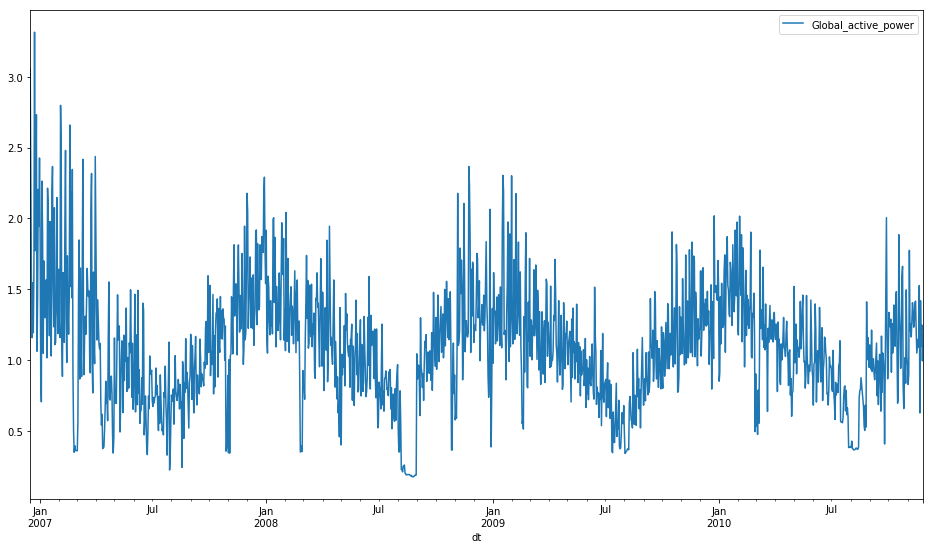

In [34]:
df.plot();

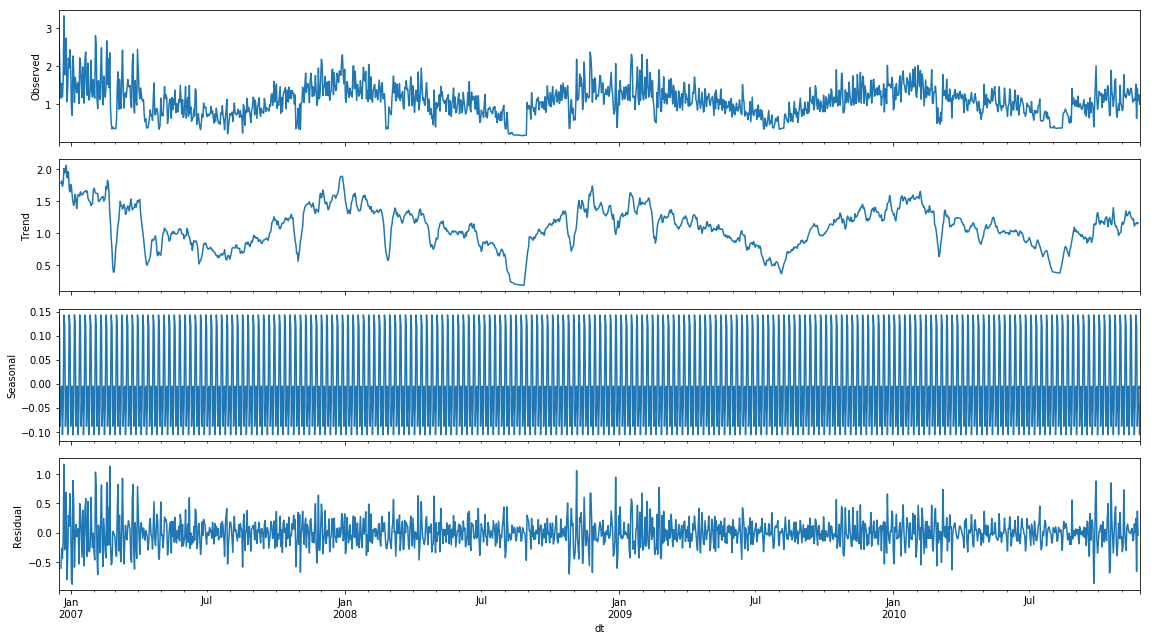

Критерий Дики-Фуллера: p=0.004304


In [35]:
decomposition = sm.tsa.seasonal_decompose(df['Global_active_power'])
fig = decomposition.plot()
plt.show()

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Global_active_power'])[1])

## Преобразование Бокса-Кокса

Это монотонное преобразование для данных, которое обычно используется для стабилизации дисперсии. Подробнее [здесь.](https://en.wikipedia.org/wiki/Power_transform) 

Для исходной последовательности $y = \{ y_1, \ldots, y_n \}, \quad y_i > 0, \quad i = 1,\ldots,n$ однопараметрическое преобразование Бокса-Кокса с параметром $\lambda$ определяется следующим образом:

$y_i^{\lambda} = \begin{cases}\frac{y_i^\lambda-1}{\lambda},&\text{if } \lambda \neq 0,\\ \log{(y_i)},& \text{if } \lambda = 0.\end{cases}$

Параметр $\lambda$ можно выбирать, максимизируя логарифм правдоподобия. Еще один способ поиска оптимального значения параметра основан на поиске максимальной величины коэффициента корреляции между квантилями функции нормального распределения и отсортированной преобразованной последовательностью.

Критерий Дики-Фуллера: p=0.000317


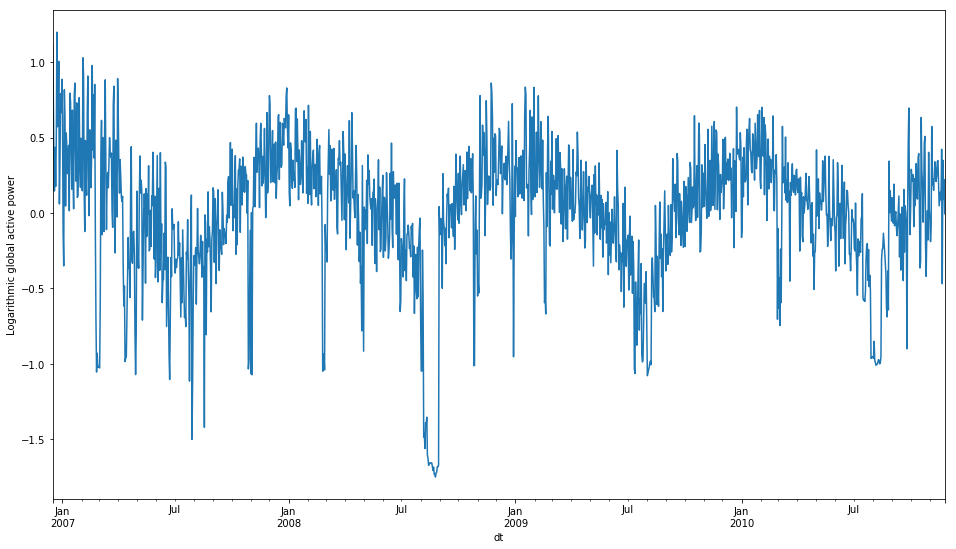

In [36]:
df['Global_active_power_log'] = np.log(df['Global_active_power'])
df['Global_active_power_log'].plot();
plt.ylabel(u'Logarithmic global active power')

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Global_active_power_log'])[1])

Выборочная автокорреляция - обычная корреляция между исходным рядом и его версией, сдвинутой на несколько отсчётов. Колличество отсчётов, на которое мы сдвигаем ряд называется **лагом автокорреляции**.  

$$\hat{\rho}_k = \frac{\sum_{t=k+1}^{T}(y_t - \bar{y})(y_{t-k}-\bar{y})}{\sum_{t=1}^{T}(y_t - \bar{y})^2} $$

### В каком диапазоне лежат значения автокорреляции? :)

Выборочная частичная автокорреляция:  

$$\hat{y}_t = * + * \cdot y_{t-1} + * \cdot y_{t_2} + \cdots + * \cdot y_{t-k+1} + \phi_{k} \cdot y_{t-k} + u_t$$

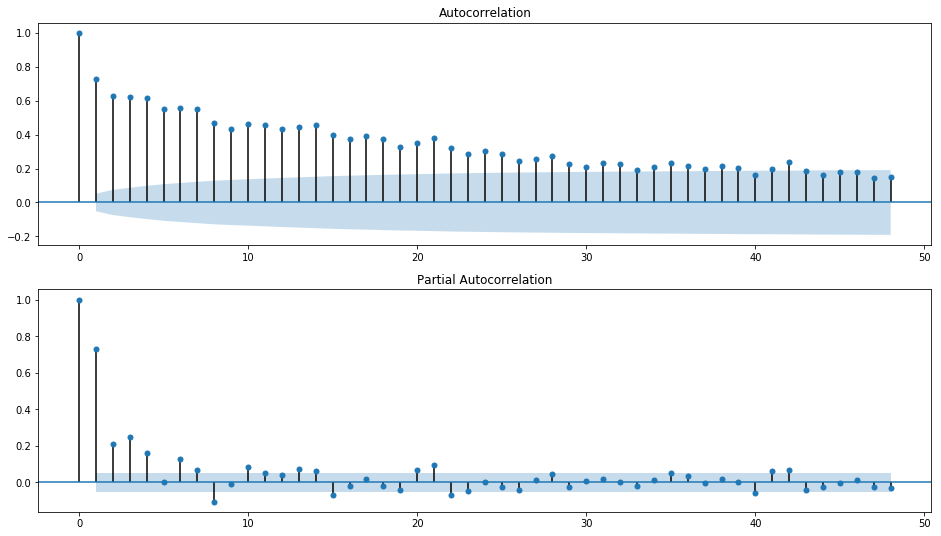

Критерий Дики-Фуллера: p=0.000317


In [37]:
ax = plt.subplot(2, 1, 1)
sm.graphics.tsa.plot_acf(df['Global_active_power_log'].dropna().values.squeeze(), lags=48, ax=ax)

ax = plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_pacf(df['Global_active_power_log'].dropna().values.squeeze(), lags=48, ax=ax)
plt.show()

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Global_active_power_log'].dropna())[1])

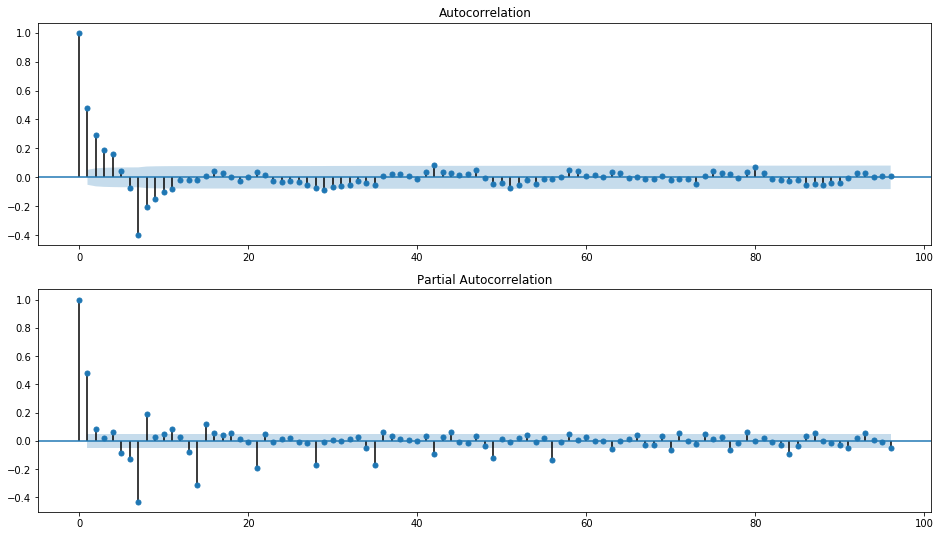

Критерий Дики-Фуллера: p=0.000000


In [38]:
df['Global_active_power_log_week'] = df['Global_active_power_log'] - df['Global_active_power_log'].shift(7)
df['Global_active_power_log_diff_week'] = df['Global_active_power_log_week'] - df['Global_active_power_log_week'].shift(1)

ax = plt.subplot(2, 1, 1)
sm.graphics.tsa.plot_acf(df['Global_active_power_log_week'].dropna().values.squeeze(), lags=96, ax=ax)

ax = plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_pacf(df['Global_active_power_log_week'].dropna().values.squeeze(), lags=96, ax=ax)
plt.show()

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Global_active_power_log_week'].dropna())[1])

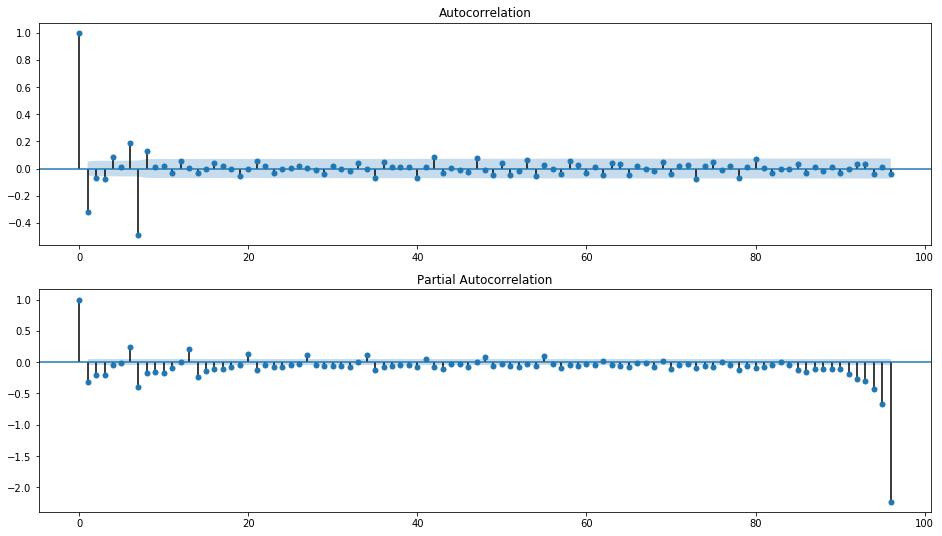

Критерий Дики-Фуллера: p=0.000000


In [39]:
ax = plt.subplot(2, 1, 1)
sm.graphics.tsa.plot_acf(df['Global_active_power_log_diff_week'].dropna().values.squeeze(), lags=96, ax=ax)

ax = plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_pacf(df['Global_active_power_log_diff_week'].dropna().values.squeeze(), lags=96, ax=ax)
plt.show()

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Global_active_power_log_diff_week'].dropna())[1])

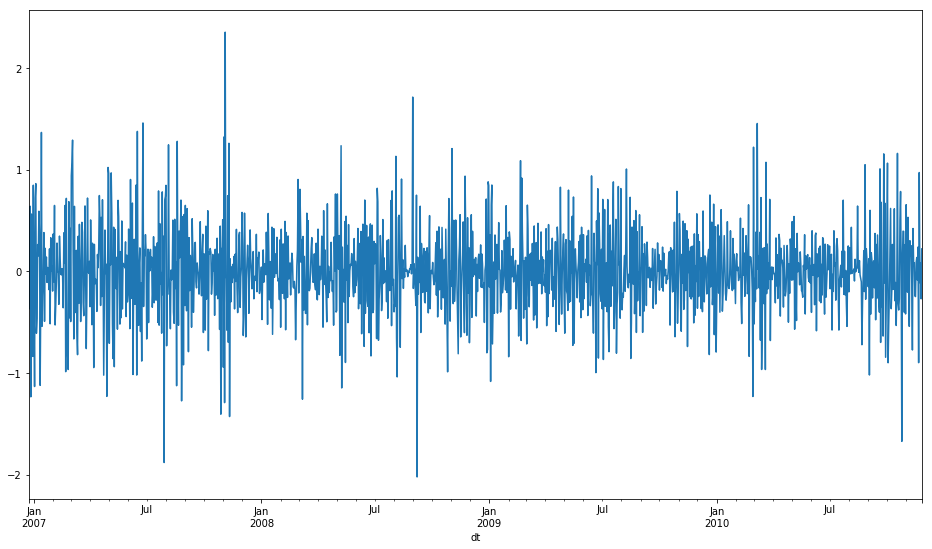

In [40]:
# Посмотрим в итоге на то, что у нас получилось.
df['Global_active_power_log_diff_week'].dropna().plot();

In [43]:
ps, Ps = range(0, 7), range(0, 4)  # parameters ps and qs in range(1, 4) introduce some kind of problem?
qs, Qs = range(0, 7), range(0, 2)
d, D = 1, 1
lag = 7

In [44]:
day_ns = df['Global_active_power_log'].index.dayofyear
day_ns

Int64Index([350, 351, 352, 353, 354, 355, 356, 357, 358, 359,
            ...
            321, 322, 323, 324, 325, 326, 327, 328, 329, 330],
           dtype='int64', name='dt', length=1442)

In [45]:
exog_season = patsy.dmatrix('bs(day_ns, df=8)')
print(exog_season.shape)
print(exog_season[:5])

exog_season2 = exog_season[:, 1:]  # bug/requirement: no constant in exog

(1442, 9)
[[1.         0.         0.         0.         0.         0.00272499
  0.08000936 0.48886692 0.42839873]
 [1.         0.         0.         0.         0.         0.00224532
  0.07111799 0.47147055 0.45516614]
 [1.         0.         0.         0.         0.         0.00182553
  0.06264618 0.45250235 0.48302594]
 [1.         0.         0.         0.         0.         0.00146162
  0.05461518 0.4319232  0.512     ]
 [1.         0.         0.         0.         0.         0.0011496
  0.04704626 0.40969399 0.54211015]]


In [46]:
train_portion = 31
train_df, test_df = df[:-train_portion], df[-train_portion:]
train_exog, test_exog = exog_season2[:-train_portion], exog_season2[-train_portion:]

In [ ]:
import itertools
import warnings

parameters = itertools.product(ps, qs, Ps, Qs)
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for parameter in list(parameters):
    # Модель обучается не на всех наборах параметров
    try:
        model=sm.tsa.statespace.SARIMAX(train_df['Global_active_power_log'], 
                                        order=(parameter[0], d, parameter[1]), 
                                        seasonal_order=(parameter[2], D, parameter[3], lag),
                                        exog=train_exog).fit(disp=-1)
    # Выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError as e:
        print('wrong parameters:', parameter)
        continue
    aic = model.aic
    # Сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_parameter = parameter
    results.append([parameter, model.aic])

In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
result_table.sort_values(by='aic', ascending=True).head()

In [47]:
params = (6, 5, 2, 0)

In [48]:
model=sm.tsa.statespace.SARIMAX(train_df['Global_active_power_log'], 
                                        order=(params[0], d, params[1]), 
                                        seasonal_order=(params[2], D, params[3], lag),
                                        exog=train_exog).fit(disp=-1)

In [49]:
best_model = model

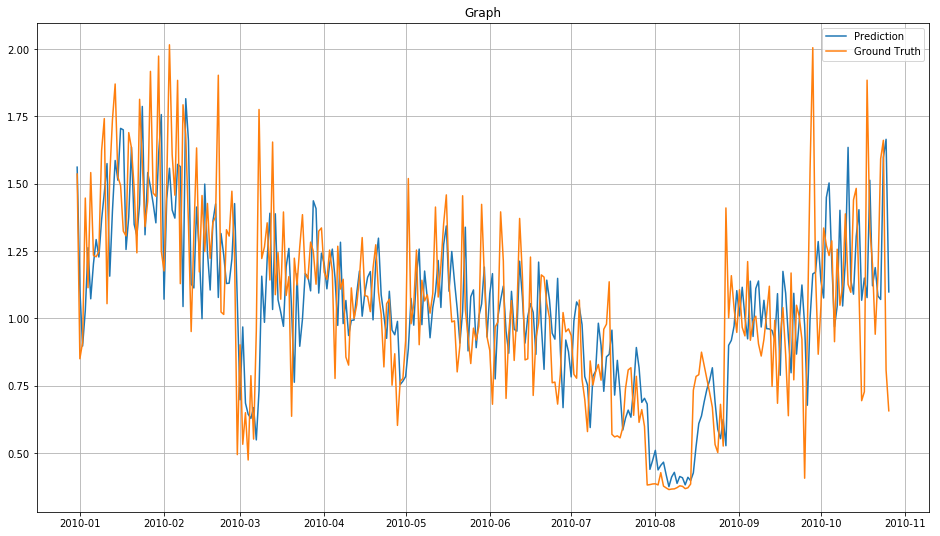

In [50]:
train_df['model'] = np.exp(best_model.fittedvalues)
plot_prediction(train_df['Global_active_power'], train_df['model'], last_n=300)

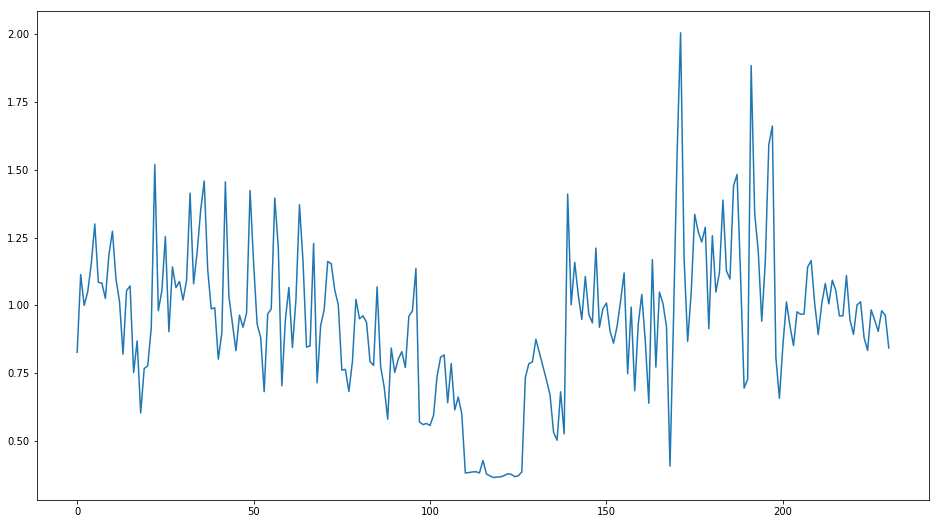

In [51]:
pred_values = np.exp(best_model.forecast(31, exog=test_exog))
plt.plot(np.concatenate([train_df['Global_active_power'].values[-200:], pred_values]));

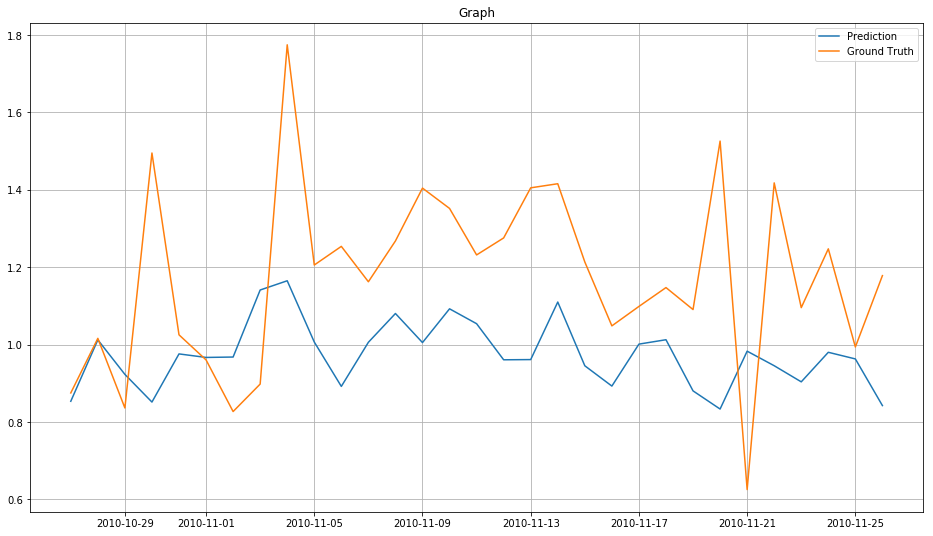

In [52]:
plot_prediction(test_df['Global_active_power'], pred_values)

In [53]:
print(f'SARIMAX MAE = {mean_abs_error(pred_values, test_df["Global_active_power"].values)}')
print(f'SARIMAX MAPE = {mean_abs_percentage_error(pred_values, test_df["Global_active_power"].values)}')

SARIMAX MAE = -0.1984758951500449
SARIMAX MAPE = -19.84758951500449


In [54]:
sarima_folder = os.path.join('models', 'sarima')
!mkdir -p {sarima_folder}

In [55]:
best_model.save(os.path.join(sarima_folder, 'model.sa'))

In [56]:
np.save(os.path.join(sarima_folder, 'exog'), test_exog)

# Fbprophet

Prophet был разработан для прогнозирования большого числа различных бизнес-показателей и строит достаточно хорошие default'ные прогнозы. Кроме того, он дает возможность, изменяя человеко-понятные параметры, улучшать прогноз и не требует от аналитиков глубоких знаний устройства предсказательных моделей.

Из минусов можно отметить достаточно небольшую точность предсказания "из коробки", для повышения качества придется повозиться с настройкой параметров.

[Статья](https://research.fb.com/prophet-forecasting-at-scale/) от Facebook про Prophet.  
[Ссылка](https://facebook.github.io/prophet/docs/quick_start.html) на официальную документацию.

In [58]:
from fbprophet import Prophet

Библиотека **Prophet** имеет интерфейс похожий на *sklearn*, сначала мы создаем модель, затем вызываем у нее метод *fit* для тренировки и *predict* для предсказания. На вход методу *fit* библиотека принимает *dataframe* с двумя колонками:

**ds** — время, поле должно быть типа date или datetime,  
**y** — числовой показатель, который мы хотим предсказывать.

In [59]:
df = data[['Global_active_power']].copy()
df = df.resample('D').apply(sum)
df.reset_index(inplace=True)
df.columns = ['ds', 'y']

In [62]:
print(df)

             ds         y
0    2006-12-16  1209.176
1    2006-12-17  3390.460
2    2006-12-18  2203.826
3    2006-12-19  1666.194
4    2006-12-20  2225.748
5    2006-12-21  1717.114
6    2006-12-22  2341.338
7    2006-12-23  4773.386
8    2006-12-24  2550.012
9    2006-12-25  2743.120
10   2006-12-26  3934.110
11   2006-12-27  1528.760
12   2006-12-28  2072.638
13   2006-12-29  3174.392
14   2006-12-30  2802.336
15   2006-12-31  3494.196
16   2007-01-01  2749.004
17   2007-01-02  1269.236
18   2007-01-03  1014.054
19   2007-01-04  3259.412
20   2007-01-05  2713.364
21   2007-01-06  1508.378
22   2007-01-07  2447.620
23   2007-01-08  2241.360
24   2007-01-09  1869.054
25   2007-01-10  2154.800
26   2007-01-11  2255.194
27   2007-01-12  1461.296
28   2007-01-13  3186.814
29   2007-01-14  3011.029
...         ...       ...
1412 2010-10-28  1463.326
1413 2010-10-29  1204.422
1414 2010-10-30  2152.700
1415 2010-10-31  1476.430
1416 2010-11-01  1383.180
1417 2010-11-02  1191.082
1418 2010-11

In [63]:
df.tail()

,ds,y
1437,2010-11-22,2041.536
1438,2010-11-23,1577.536
1439,2010-11-24,1796.248
1440,2010-11-25,1431.164
1441,2010-11-26,1488.104


In [64]:
prediction_size = 31

df = data[['Global_active_power']].copy()
df = df.resample('D').apply(sum)
df.reset_index(inplace=True)
df.columns = ['ds', 'y']
df.tail()

,ds,y
1437,2010-11-22,2041.536
1438,2010-11-23,1577.536
1439,2010-11-24,1796.248
1440,2010-11-25,1431.164
1441,2010-11-26,1488.104


In [65]:
train_df = df[:-prediction_size]

In [66]:
model = Prophet(daily_seasonality=True)
model.fit(train_df);

Для того что бы построить предсказания методу *predict* нужно передать *dataframe* с количеством записей, равным периоду, на который нужно предсказать.

In [67]:
future_dataframe = model.make_future_dataframe(periods=prediction_size, freq='D')
future_dataframe.tail()

,ds
1437,2010-11-22
1438,2010-11-23
1439,2010-11-24
1440,2010-11-25
1441,2010-11-26


In [68]:
forecast = model.predict(future_dataframe)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1437,2010-11-22,1256.592878,1498.368886,2533.102712,1256.515672,1256.676278,753.981302,753.981302,753.981302,347.387396,...,-130.351356,-130.351356,-130.351356,536.945263,536.945263,536.945263,0.0,0.0,0.0,2010.574180
1438,2010-11-23,1256.689284,1623.072450,2694.841186,1256.607064,1256.779932,870.111966,870.111966,870.111966,347.387396,...,-19.285752,-19.285752,-19.285752,542.010322,542.010322,542.010322,0.0,0.0,0.0,2126.801250
1439,2010-11-24,1256.785690,1573.368411,2690.381328,1256.696873,1256.883357,887.012466,887.012466,887.012466,347.387396,...,-3.948141,-3.948141,-3.948141,543.573212,543.573212,543.573212,0.0,0.0,0.0,2143.798156
1440,2010-11-25,1256.882096,1430.570191,2514.648700,1256.787819,1256.987123,728.828080,728.828080,728.828080,347.387396,...,-160.452695,-160.452695,-160.452695,541.893380,541.893380,541.893380,0.0,0.0,0.0,1985.710176
1441,2010-11-26,1256.978501,1481.924357,2621.547684,1256.875901,1257.091704,817.456432,817.456432,817.456432,347.387396,...,-67.231791,-67.231791,-67.231791,537.300828,537.300828,537.300828,0.0,0.0,0.0,2074.434933


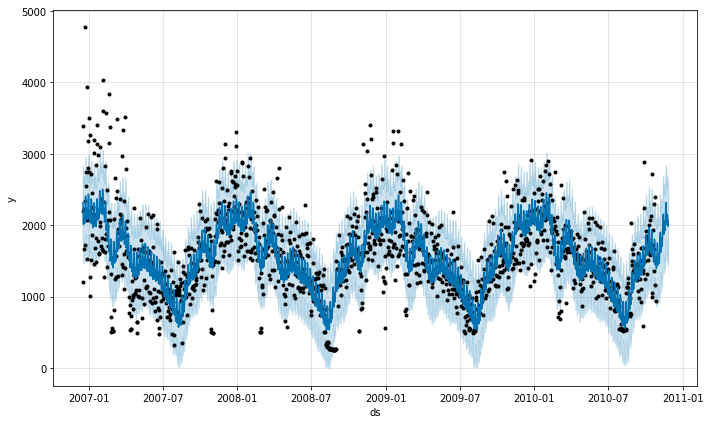

In [69]:
model.plot(forecast);

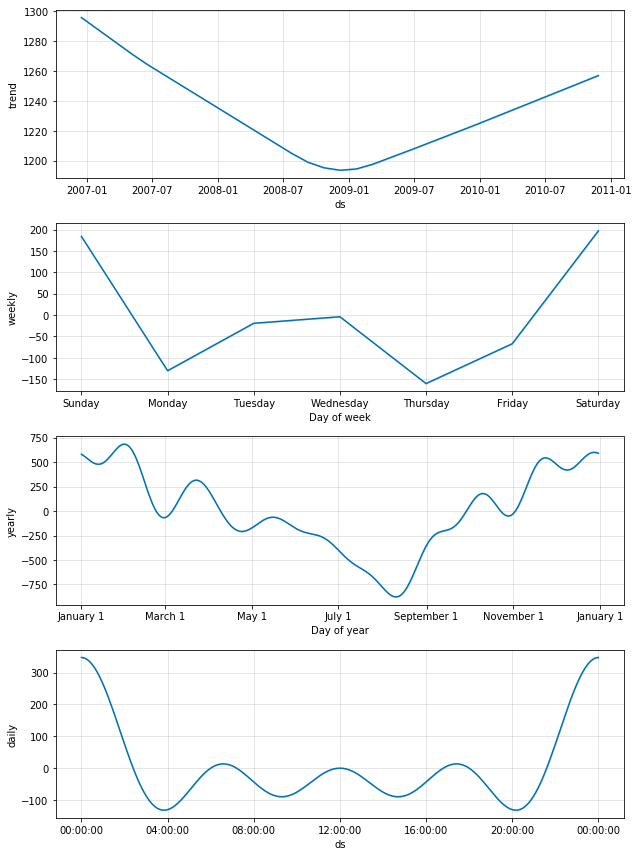

In [70]:
model.plot_components(forecast);

In [71]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [72]:
cmp_df = make_comparison_dataframe(df, forecast)

mape = mean_abs_percentage_error(cmp_df['y'][-prediction_size:], cmp_df['yhat'][-prediction_size:])
mae = mean_abs_error(cmp_df['y'][-prediction_size:], cmp_df['yhat'][-prediction_size:])

print(f'Prophet MAPE = {mape},\nProphet MAE = {mae}')

Prophet MAPE = -16564.643692521615,
Prophet MAE = -165.64643692521614


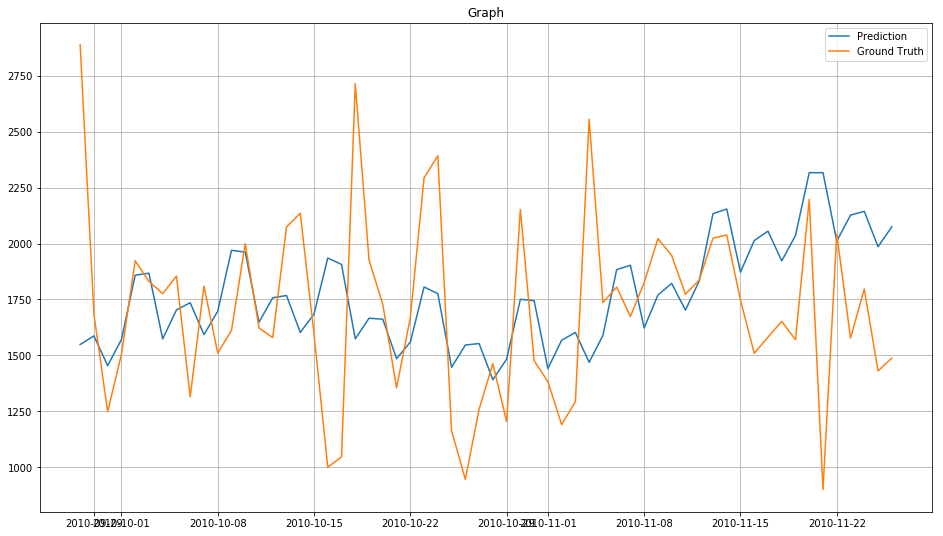

In [73]:
plot_prediction(cmp_df['y'], cmp_df['yhat'])

In [74]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [75]:
df_with_boxcox = df.copy().set_index('ds')
df_with_boxcox['y'], lambda_ = np.log(df_with_boxcox['y']), 0
df_with_boxcox.reset_index(inplace=True)

In [76]:
pd.concat([df_with_boxcox, df.y], axis=1).head()

,ds,y,y
0,2006-12-16,7.097694,1209.176
1,2006-12-17,8.128721,3390.460
2,2006-12-18,7.697950,2203.826
3,2006-12-19,7.418297,1666.194
4,2006-12-20,7.707848,2225.748


In [77]:
train_df_wb = df_with_boxcox[:-prediction_size]

model_wb = Prophet(daily_seasonality=True)
model_wb.fit(train_df_wb);

In [78]:
future_df_wb = model_wb.make_future_dataframe(periods=prediction_size, freq='D')
future_df_wb.tail()

,ds
1437,2010-11-22
1438,2010-11-23
1439,2010-11-24
1440,2010-11-25
1441,2010-11-26


In [79]:
forecast_wb = model_wb.predict(future_df_wb)
forecast_wb.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1437,2010-11-22,7.193776,7.237043,8.047780,7.193495,7.194157,0.455643,0.455643,0.455643,0.146876,...,-0.073720,-0.073720,-0.073720,0.382487,0.382487,0.382487,0.0,0.0,0.0,7.649418
1438,2010-11-23,7.193904,7.321851,8.099576,7.193583,7.194313,0.531023,0.531023,0.531023,0.146876,...,-0.003671,-0.003671,-0.003671,0.387818,0.387818,0.387818,0.0,0.0,0.0,7.724927
1439,2010-11-24,7.194032,7.368324,8.135204,7.193690,7.194509,0.544270,0.544270,0.544270,0.146876,...,0.006993,0.006993,0.006993,0.390401,0.390401,0.390401,0.0,0.0,0.0,7.738303
1440,2010-11-25,7.194161,7.232384,8.035356,7.193807,7.194678,0.440610,0.440610,0.440610,0.146876,...,-0.096641,-0.096641,-0.096641,0.390375,0.390375,0.390375,0.0,0.0,0.0,7.634771
1441,2010-11-26,7.194289,7.323469,8.090752,7.193902,7.194848,0.508398,0.508398,0.508398,0.146876,...,-0.026417,-0.026417,-0.026417,0.387939,0.387939,0.387939,0.0,0.0,0.0,7.702687


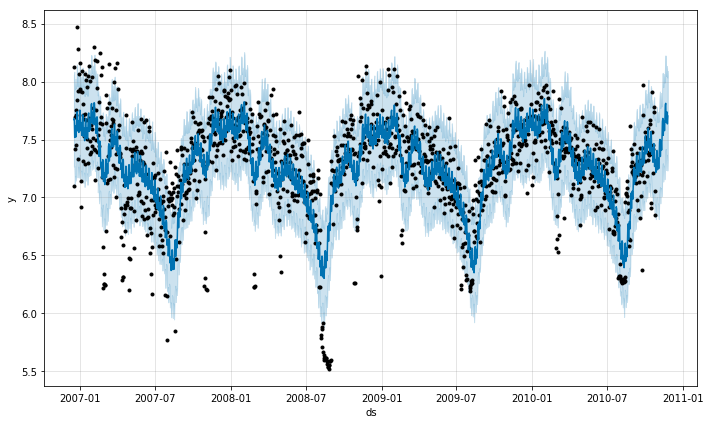

In [80]:
model_wb.plot(forecast_wb);

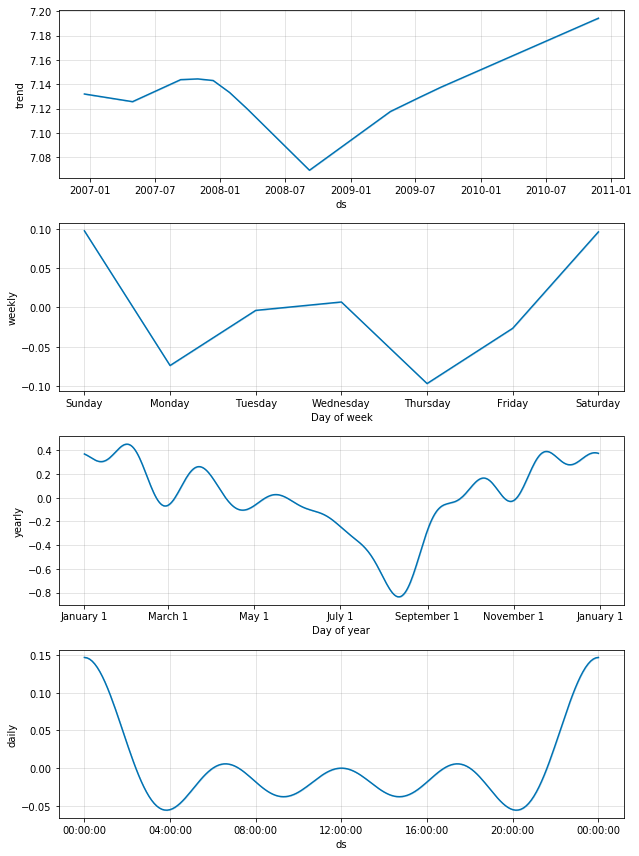

In [81]:
model_wb.plot_components(forecast_wb);

In [82]:
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_wb[column] = inverse_boxcox(forecast_wb[column], lambda_)

In [89]:
cmp_df_wb = make_comparison_dataframe(df, forecast_wb)
mape_wb = mean_abs_percentage_error(cmp_df_wb['y'][-prediction_size:], cmp_df_wb['yhat'][-prediction_size:])
mae_wb = mean_abs_error(cmp_df_wb['y'][-prediction_size:], cmp_df_wb['yhat'][-prediction_size:])

print(f'MAPE = {mape:.2f}, MAPE with Box-Cox = {mape_wb:.2f}')
print(f'MAE = {mae:.2f}, MAE with Box-Cox = {mae_wb:.2f}')

MAPE = -16564.64, MAPE with Box-Cox = 23.78
MAE = -165.65, MAE with Box-Cox = 353.98


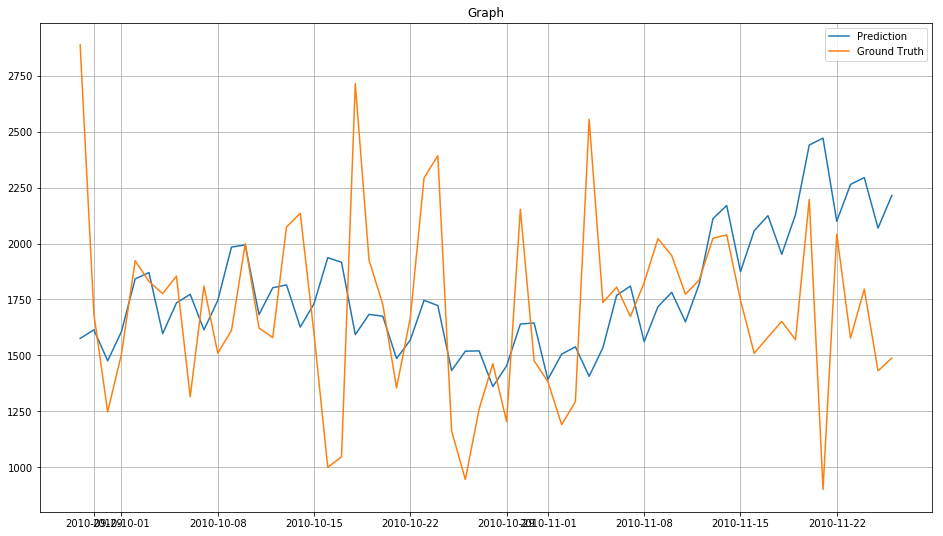

In [84]:
plot_prediction(cmp_df_wb['y'], cmp_df_wb['yhat'])

In [85]:
!mkdir -p ./models/fbprophet/
import pickle
with open('models/fbprophet/model.pkl', 'wb') as f:
    pickle.dump(model, f)

# LSTM

**RNNS**
<img src='./images/RNN_types.jpeg'>

<img src="./images/RNN.png">

<img src='./images/RNNnotation.png'>

**LSTM - Long-Short-term Memory**

Данный вид рекуррентных нейронных сетей позволяет сохранять как длительные, так и коротковременные зависимости в последовательностях данных. Это происходит за счёт особой архитектуры сети, которую вы можете увидеть ниже  

<img src='./images/LSTM.png'>

В каждой ячейке имеется вход новых данных и вход предыдущего состояния. А также ячейка имеет свое "состояние", благодаря которому сеть и "запоминает" данные.  

$$f = \sigma(W_f [h_{t-1}; x_t] + b_f)$$  
$$i = \sigma(W_i [h_{t-1}; x_t] + b_i)$$  
$$o = \sigma(W_o [h_{t-1}; x_t] + b_o)$$  

$$\tilde c_{t} = tanh(W_h [h_{t-1}; x_t] + b_h)$$  
$$c_t = f \odot c_{t-1} + i \odot \tilde c_t$$  

$$h_t = o \odot tanh(c_t)$$

In [90]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [91]:
df_resample = data.resample('h').mean() 
df_resample.shape

(34589, 7)

In [92]:
values = df_resample.values 

In [93]:
values.shape

(34589, 7)

In [94]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [95]:
reframed = series_to_supervised(scaled, 7, 1)

reframed.drop(reframed.columns[50:], axis=1, inplace=True)
print(reframed.head())

    var1(t-7)  var2(t-7)  var3(t-7)  var4(t-7)  var5(t-7)  var6(t-7)  \
7    0.636816   0.295738   0.337945   0.631157        0.0   0.011366   
8    0.545045   0.103358   0.335501   0.541487        0.0   0.144652   
9    0.509006   0.110073   0.283802   0.502152        0.0   0.030869   
10   0.488550   0.096987   0.315987   0.481110        0.0   0.000000   
11   0.455597   0.099010   0.434417   0.449904        0.0   0.008973   

    var7(t-7)  var1(t-6)  var2(t-6)  var3(t-6)  ...  var6(t-2)  var7(t-2)  \
7    0.687521   0.545045   0.103358   0.335501  ...   0.002872   0.180772   
8    0.687748   0.509006   0.110073   0.283802  ...   0.001795   0.000000   
9    0.680272   0.488550   0.096987   0.315987  ...   0.010050   0.000000   
10   0.684350   0.455597   0.099010   0.434417  ...   0.543431   0.000000   
11   0.702019   0.322555   0.072536   0.495847  ...   0.012204   0.000000   

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
7    0.301032   0.092251   0.567

In [97]:
values = reframed.values

n_train_time = 365*24*3
train = values[:n_train_time, :]
test = values[n_train_time:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape(-1, 7, 7)
test_X = test_X.reshape(-1, 7, 7)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(26280, 7, 7) (26280,) (8302, 7, 7) (8302,)


In [98]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [118]:
from keras.optimizers import Adam

In [122]:
def create_lstm_model():
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(LSTM(40, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(20, return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(10))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

In [123]:
model = create_lstm_model()

In [124]:
history = model.fit(train_X, train_y, epochs=20, batch_size=70,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 26280 samples, validate on 8302 samples
Epoch 1/20
 - 18s - loss: 0.1077 - val_loss: 0.0913
Epoch 2/20
 - 13s - loss: 0.0930 - val_loss: 0.0725
Epoch 3/20
 - 14s - loss: 0.0818 - val_loss: 0.0661
Epoch 4/20
 - 14s - loss: 0.0772 - val_loss: 0.0649
Epoch 5/20
 - 11s - loss: 0.0754 - val_loss: 0.0641
Epoch 6/20
 - 10s - loss: 0.0740 - val_loss: 0.0635
Epoch 7/20
 - 10s - loss: 0.0734 - val_loss: 0.0630
Epoch 8/20
 - 10s - loss: 0.0725 - val_loss: 0.0628
Epoch 9/20
 - 11s - loss: 0.0723 - val_loss: 0.0618
Epoch 10/20
 - 11s - loss: 0.0715 - val_loss: 0.0623
Epoch 11/20
 - 11s - loss: 0.0711 - val_loss: 0.0611
Epoch 12/20
 - 10s - loss: 0.0713 - val_loss: 0.0613
Epoch 13/20
 - 12s - loss: 0.0708 - val_loss: 0.0612
Epoch 14/20
 - 12s - loss: 0.0707 - val_loss: 0.0612
Epoch 15/20
 - 11s - loss: 0.0706 - val_loss: 0.0607
Epoch 16/20
 - 11s - loss: 0.0705 - val_loss: 0.0600
Epoch 17/20
 - 12s - loss: 0.0703 - val_loss: 0.0599
Epoch 18/20
 - 11s - loss: 0.0701 - val_loss: 0.0598
Epoch 

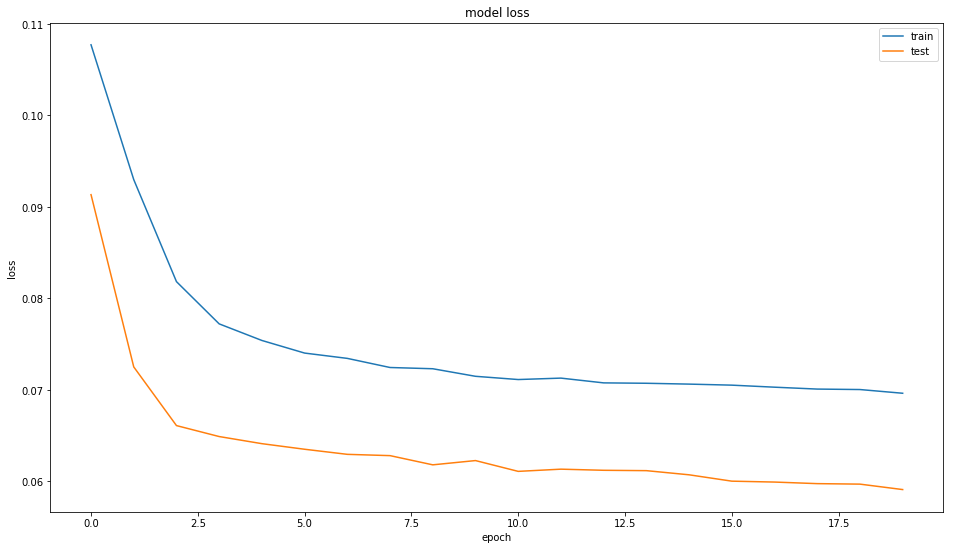

In [125]:
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    
# summarize history for loss
plot_history(history)

In [126]:
def convert_predictions(predictions, test_X, test_y, scaler):
    test_X_ = test_X[:, 0, :]
    # invert scaling for forecast
    inv_yhat = np.concatenate((predictions, test_X_[:, -6:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X_[:, -6:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    return inv_y, inv_yhat
    
# make a prediction
yhat = model.predict(test_X)
inv_y, inv_yhat = convert_predictions(yhat, test_X, test_y, scaler)

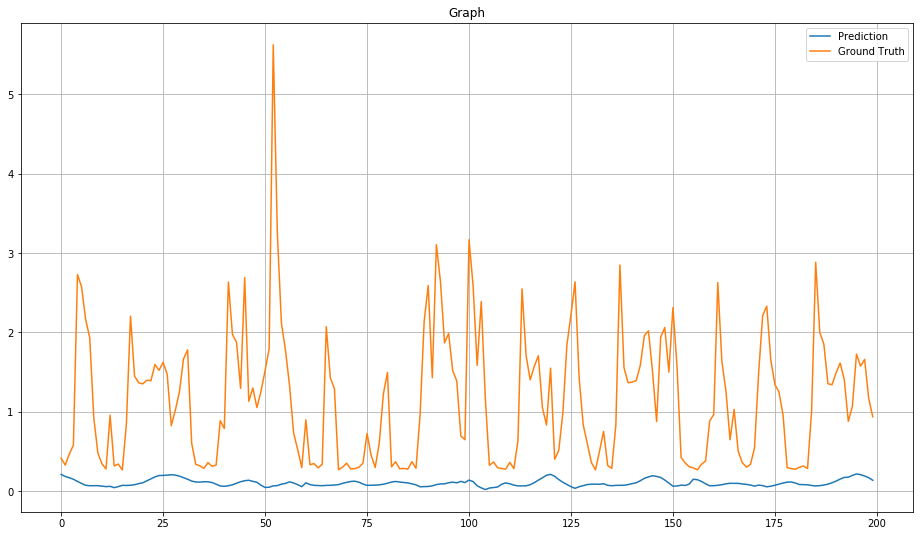

In [116]:
plot_prediction(inv_y, inv_yhat, last_n=200)

In [110]:
print(f'LSTM MAE = {mean_abs_error(inv_y, inv_yhat)}')
print(f'LSTM MAPE = {mean_abs_percentage_error(inv_y, inv_yhat)}\n')

LSTM MAE = 0.3983466748136461
LSTM MAPE = 54.422696954101866



In [127]:
def save_model(model, scaler, folder_name):
    model_folder = os.path.join('models', folder_name)
    model_json_path = os.path.join(model_folder, 'model.json')
    weights_path = os.path.join(model_folder, 'weights.hd5')
    scaler_path = os.path.join(model_folder, 'scaler.pkl')

    !mkdir -p {model_folder}

    with open(model_json_path, 'w') as f:
        json.dump(model.to_json(), f)
    model.save_weights(weights_path)

    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)

In [128]:
save_model(model, scaler, 'lstm_keras_h')

In [129]:
def train_lstm(dataset, n_train_time):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(dataset)
    
    reframed = series_to_supervised(scaled, 7, 1)
    reframed.drop(reframed.columns[50:], axis=1, inplace=True)
    
    values = reframed.values

    train = values[:n_train_time, :]
    test = values[n_train_time:, :]

    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 7, 7))
    test_X = test_X.reshape((test_X.shape[0], 7, 7))

    model = create_lstm_model()
    history = model.fit(train_X, train_y, epochs=20, batch_size=70,
                        validation_data=(test_X, test_y), verbose=2, shuffle=False)

    # summarize history for loss
    plot_history(history)
    
    yhat = model.predict(test_X)
    inv_y, inv_yhat = convert_predictions(yhat, test_X, test_y, scaler)    
    plot_prediction(inv_y, inv_yhat, last_n=200)
    
    print(f'LSTM MAE = {mean_abs_error(inv_y, inv_yhat)}')
    print(f'LSTM MAPE = {mean_abs_percentage_error(inv_y, inv_yhat)}\n')
    
    return model, scaler

Train on 1095 samples, validate on 340 samples
Epoch 1/20
 - 9s - loss: 0.1927 - val_loss: 0.0759
Epoch 2/20
 - 1s - loss: 0.1365 - val_loss: 0.0884
Epoch 3/20
 - 0s - loss: 0.1222 - val_loss: 0.0734
Epoch 4/20
 - 0s - loss: 0.1210 - val_loss: 0.0776
Epoch 5/20
 - 0s - loss: 0.1170 - val_loss: 0.0686
Epoch 6/20
 - 0s - loss: 0.1106 - val_loss: 0.0740
Epoch 7/20
 - 0s - loss: 0.1124 - val_loss: 0.0690
Epoch 8/20
 - 0s - loss: 0.1091 - val_loss: 0.0682
Epoch 9/20
 - 0s - loss: 0.1032 - val_loss: 0.0703
Epoch 10/20
 - 0s - loss: 0.1044 - val_loss: 0.0729
Epoch 11/20
 - 0s - loss: 0.1020 - val_loss: 0.0727
Epoch 12/20
 - 1s - loss: 0.0998 - val_loss: 0.0648
Epoch 13/20
 - 0s - loss: 0.1010 - val_loss: 0.0687
Epoch 14/20
 - 0s - loss: 0.1005 - val_loss: 0.0681
Epoch 15/20
 - 0s - loss: 0.0969 - val_loss: 0.0700
Epoch 16/20
 - 0s - loss: 0.0944 - val_loss: 0.0707
Epoch 17/20
 - 1s - loss: 0.0970 - val_loss: 0.0678
Epoch 18/20
 - 0s - loss: 0.0973 - val_loss: 0.0701
Epoch 19/20
 - 0s - loss: 

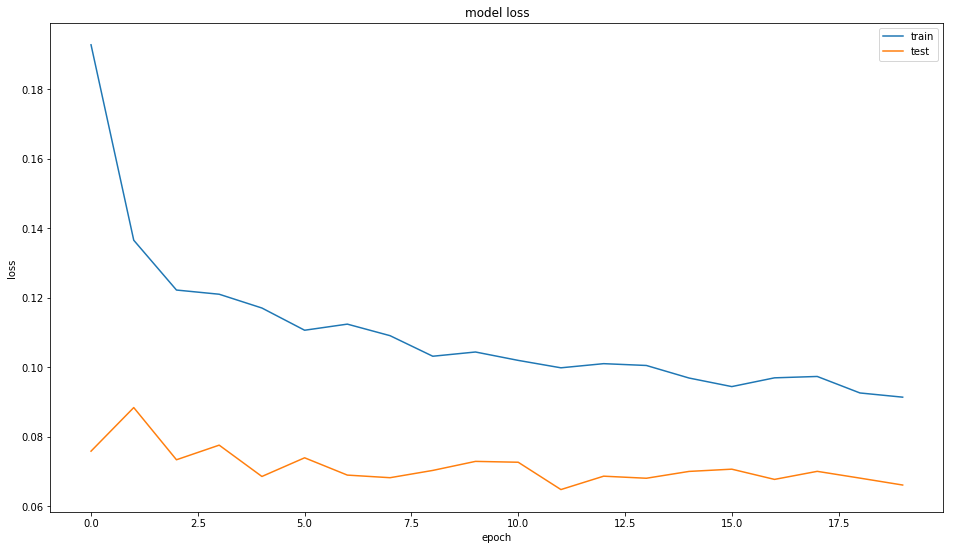

LSTM MAE = 0.20772499610502715
LSTM MAPE = 21.460442456243918



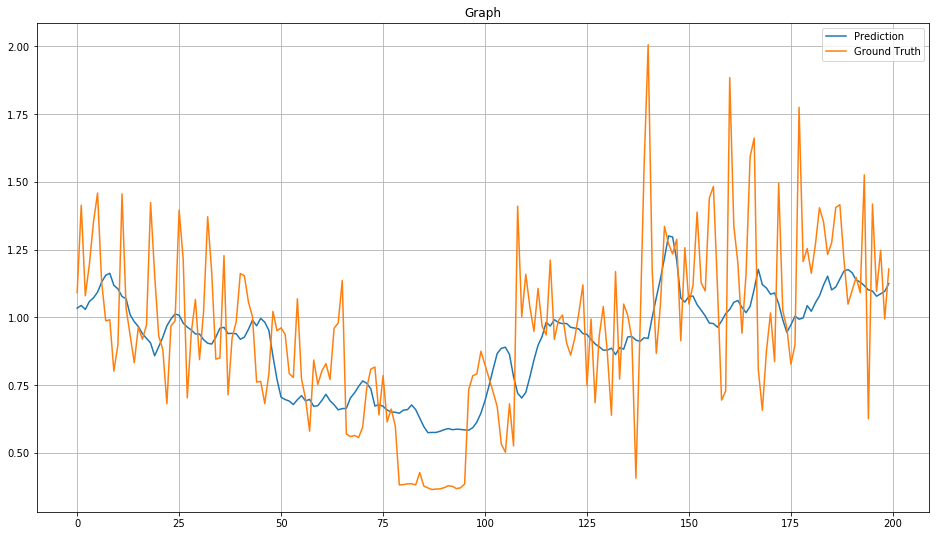

In [130]:
model, scaler = train_lstm(data.resample('d').mean(), 365*3)

In [131]:
save_model(model, scaler, 'lstm_keras_d_mean')

Train on 1095 samples, validate on 340 samples
Epoch 1/20
 - 10s - loss: 0.1650 - val_loss: 0.0836
Epoch 2/20
 - 1s - loss: 0.1304 - val_loss: 0.0931
Epoch 3/20
 - 0s - loss: 0.1200 - val_loss: 0.0771
Epoch 4/20
 - 0s - loss: 0.1204 - val_loss: 0.0786
Epoch 5/20
 - 1s - loss: 0.1169 - val_loss: 0.0752
Epoch 6/20
 - 0s - loss: 0.1117 - val_loss: 0.0714
Epoch 7/20
 - 0s - loss: 0.1117 - val_loss: 0.0795
Epoch 8/20
 - 1s - loss: 0.1070 - val_loss: 0.0680
Epoch 9/20
 - 0s - loss: 0.1067 - val_loss: 0.0720
Epoch 10/20
 - 1s - loss: 0.1063 - val_loss: 0.0735
Epoch 11/20
 - 1s - loss: 0.1010 - val_loss: 0.0703
Epoch 12/20
 - 1s - loss: 0.1014 - val_loss: 0.0669
Epoch 13/20
 - 1s - loss: 0.1036 - val_loss: 0.0778
Epoch 14/20
 - 1s - loss: 0.0976 - val_loss: 0.0669
Epoch 15/20
 - 1s - loss: 0.0965 - val_loss: 0.0665
Epoch 16/20
 - 1s - loss: 0.0973 - val_loss: 0.0666
Epoch 17/20
 - 1s - loss: 0.0942 - val_loss: 0.0658
Epoch 18/20
 - 1s - loss: 0.0950 - val_loss: 0.0666
Epoch 19/20
 - 1s - loss:

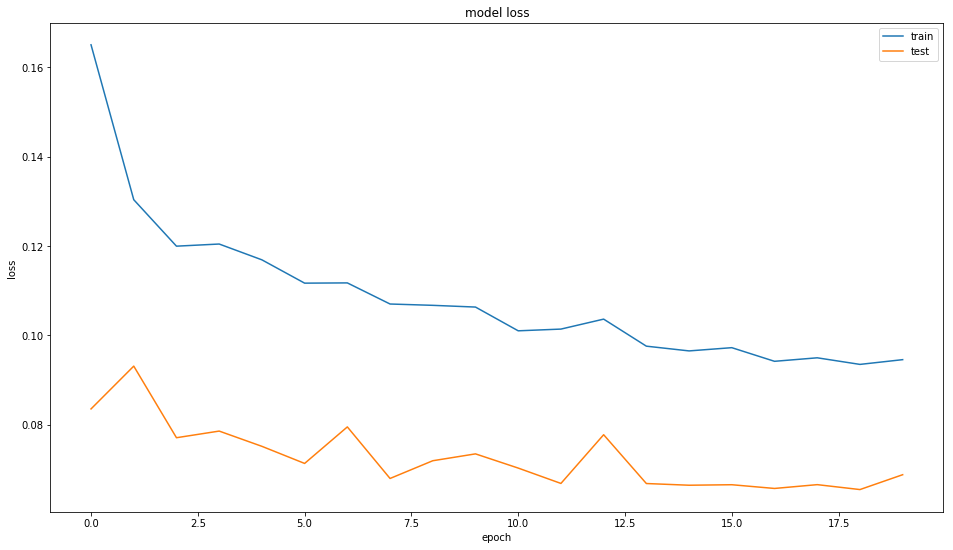

LSTM MAE = 311.3604654482101
LSTM MAPE = 21.427073205883833



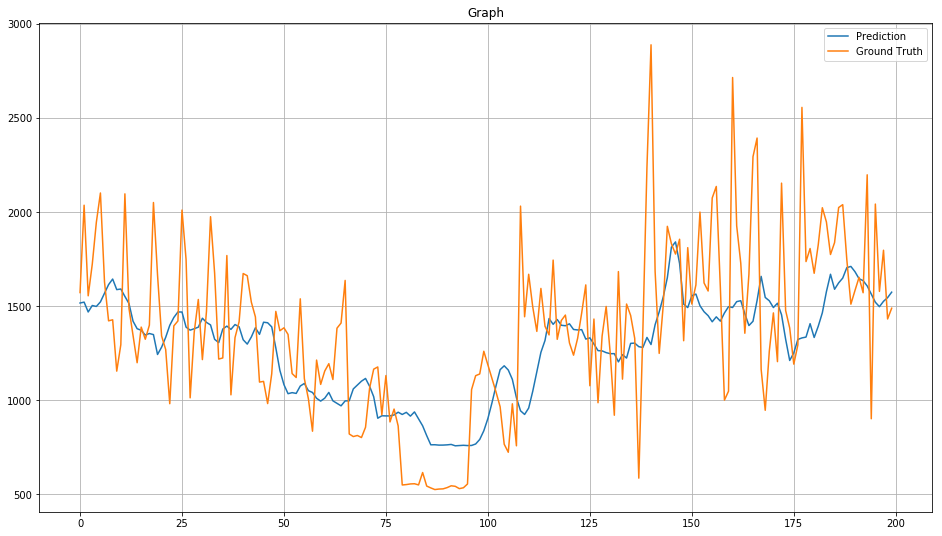

In [132]:
model, scaler = train_lstm(data.resample('d').sum(), 365*3)

In [133]:
save_model(model, scaler, 'lstm_keras_d_sum')

In [134]:
model, scaler = train_lstm(data.resample('h').mean(), 365*24*3)

KeyboardInterrupt: 

# LightGBM

In [135]:
import lightgbm as lgb

**LightGBM** это одна из самых популярных библиотек для градиентного бустинга. Основные её преимущества в том, что она эффективна по памяти и действительно быстрая (бонусом идёт возможность работать с большими массивами данных и sparse матрицами).

[Ссылка](https://lightgbm.readthedocs.io/en/latest/) на официальную документацию.

## Задание: придумайте признаки для модели

In [136]:
def mean_encoding(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [139]:
def prepare_df(data, target_column, lag_start=1, lag_end=2, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data) * (1 - test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for column in data.columns:
        for i in range(lag_start, lag_end):
            data[f"{column}_t-{i}"] = data[column].shift(i)
        if column != target_column:
            data.drop(column, axis=1, inplace=True)
        
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5, 6]) * 1
    
    # считаем средние только по тренировочной части, чтобы избежать лика
    data[f'{target_column}_weekday_average'] = list(map(mean_encoding(data[:test_index], 'weekday',
                                                                      target_column).get, data.weekday))
    data[f"{target_column}_hour_average"] = list(map(mean_encoding(data[:test_index], 'hour',
                                                                   target_column).get, data.hour))

    group = list(data.groupby(['hour', f"{target_column}_hour_average"]).indices)
    h_mean = [m for h, m in group]
    group = list(data.groupby(['weekday', f"{target_column}_weekday_average"]).indices)
    w_mean = [m for w, m in group]
    
    # выкидываем закодированные средними признаки
    data.drop(["hour", "weekday"], axis=1, inplace=True)

    
    data = data.dropna()
    data = data.reset_index(drop=True)
    
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop([target_column], axis=1)
    y_train = data.loc[:test_index][target_column]
    X_test = data.loc[test_index:].drop([target_column], axis=1)
    y_test = data.loc[test_index:][target_column]
    
    return X_train, X_test, y_train, y_test, w_mean, h_mean

In [140]:
X_train, X_test, y_train, y_test, w_mean, h_mean = prepare_df(data.resample('h').mean(),
                                                              "Global_active_power",
                                                              lag_end=7,
                                                              test_size=0.15)

In [141]:
X_train.head()

,Global_active_power_t-1,Global_active_power_t-2,Global_active_power_t-3,Global_active_power_t-4,Global_active_power_t-5,Global_active_power_t-6,Global_reactive_power_t-1,Global_reactive_power_t-2,Global_reactive_power_t-3,Global_reactive_power_t-4,...,Sub_metering_2_t-6,Sub_metering_3_t-1,Sub_metering_3_t-2,Sub_metering_3_t-3,Sub_metering_3_t-4,Sub_metering_3_t-5,Sub_metering_3_t-6,is_weekend,Global_active_power_weekday_average,Global_active_power_hour_average
0,2.200133,3.056467,3.268567,3.400233,3.632200,4.222889,0.056167,0.076667,0.075100,0.085233,...,0.527778,4.433333,17.216667,16.783333,16.683333,16.866667,16.861111,1,1.270925,0.911849
1,2.061600,2.200133,3.056467,3.268567,3.400233,3.632200,0.071433,0.056167,0.076667,0.075100,...,6.716667,0.000000,4.433333,17.216667,16.783333,16.683333,16.866667,1,1.250129,0.662140
2,1.882467,2.061600,2.200133,3.056467,3.268567,3.400233,0.102433,0.071433,0.056167,0.076667,...,1.433333,0.000000,0.000000,4.433333,17.216667,16.783333,16.683333,1,1.250129,0.536781
3,3.349400,1.882467,2.061600,2.200133,3.056467,3.268567,0.136933,0.102433,0.071433,0.056167,...,0.000000,0.000000,0.000000,0.000000,4.433333,17.216667,16.783333,1,1.250129,0.476119
4,1.587267,3.349400,1.882467,2.061600,2.200133,3.056467,0.078233,0.136933,0.102433,0.071433,...,0.416667,0.000000,0.000000,0.000000,0.000000,4.433333,17.216667,1,1.250129,0.445037


In [142]:
# Логарифмируем таргет (частный случай преобразования Бокса-Кокса)
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [143]:
lgb_train = lgb.Dataset(X_train, y_train_log)
lgb_test = lgb.Dataset(X_test, y_test_log, reference=lgb_train)

In [144]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'learning_rate': 0.005,
    'verbose': 0
}

gbm = lgb.train(params,
                lgb_train,
                verbose_eval=False,
                valid_sets=lgb_test,
                num_boost_round=10000,
                early_stopping_rounds=50)

In [145]:
# Не забываем про обратное преобразование
y_pred = np.exp(gbm.predict(X_test))

print(f'GBM MAE = {mean_abs_error(y_test, y_pred)}')
print(f'GBM MAPE = {mean_abs_percentage_error(y_test, y_pred)}\n')

GBM MAE = 0.29329414120816744
GBM MAPE = 33.835129928517574



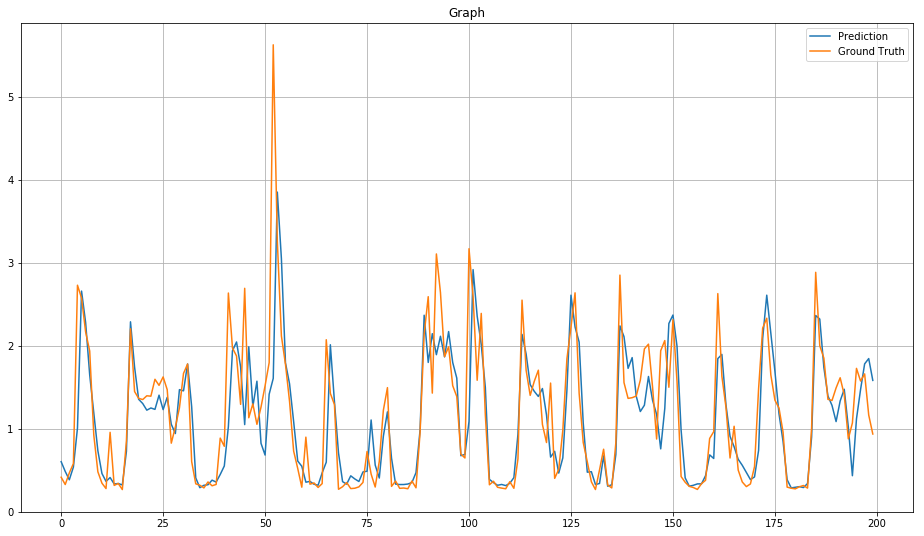

In [146]:
plot_prediction(y_test.values, y_pred, last_n=200)

In [147]:
!mkdir -p ./models/light_gbm_h_mean/
gbm.save_model('models/light_gbm_h_mean/weights.gbm');
with open('models/light_gbm_h_mean/data.pkl', 'wb') as f:
    pickle.dump((w_mean, h_mean), f)

### Дублируем то же самое на дневных суммах и дневных средних

In [148]:
def train_lgb(dataset):
    X_train, X_test, y_train, y_test, w_mean, h_mean = prepare_df(dataset,
                                                                  "Global_active_power",
                                                                  lag_end=7,
                                                                  test_size=0.15)
    y_train_log = np.log(y_train)
    y_test_log = np.log(y_test)

    lgb_train = lgb.Dataset(X_train, y_train_log)
    lgb_test = lgb.Dataset(X_test, y_test_log, reference=lgb_train)

    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'learning_rate': 0.005,
        'verbose': 0
    }

    gbm = lgb.train(params,
                    lgb_train,
                    verbose_eval=False,
                    valid_sets=lgb_test,
                    num_boost_round=10000,
                    early_stopping_rounds=50)
    # Не забываем про обратное преобразование
    y_pred = np.exp(gbm.predict(X_test))

    print(f'GBM MAE = {mean_abs_error(y_test, y_pred)}')
    print(f'GBM MAPE = {mean_abs_percentage_error(y_test, y_pred)}\n')
   
    
    return gbm, w_mean, h_mean

In [149]:
gbm, w_mean, h_mean = train_lgb(data.resample('D').mean())
!mkdir -p ./models/light_gbm_d_mean/
gbm.save_model('models/light_gbm_d_mean/weights.gbm');
with open('models/light_gbm_d_mean/data.pkl', 'wb') as f:
    pickle.dump((w_mean, h_mean), f)

GBM MAE = 0.170718252727682
GBM MAPE = 18.913392248093587



In [150]:
gbm, w_mean, h_mean = train_lgb(data.resample('D').sum())
!mkdir -p ./models/light_gbm_d_sum/
gbm.save_model('models/light_gbm_d_sum/weights.gbm');
with open('models/light_gbm_d_sum/data.pkl', 'wb') as f:
    pickle.dump((w_mean, h_mean), f)

GBM MAE = 246.44262082982638
GBM MAPE = 19.277422429811345

